In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, ".")

from config import DOCUMENT_PATHS, EMBEDDING_MODELS, TOP_K, RELEVANCE_THRESHOLD
from src.document_loader import load_all_documents
from src.chunking import chunk_sections
from src.embeddings import get_embedding_model
from src.vectorstore import build_vectorstore
from src.retrieval import retrieve, print_retrieval_results
from src.generation import generate_answer
from src.chatbot import ask
from src.evaluation import (
    EVAL_DATASET,
    evaluate_retrieval, compute_retrieval_summary, print_retrieval_summary,
    evaluate_generation, compute_generation_summary, print_generation_summary,
    compare_embeddings,
)
from src.visualization import (
    comparison_to_dataframe,
    plot_retrieval_comparison, plot_build_timings,
    plot_generation_scores, plot_generation_summary,
    generation_results_to_dataframe,
)

print("✅ All imports OK")

✅ All imports OK


# Load & chunk

In [2]:
# ── Load markdown documents into sections ──
print("Loading documents...")
sections = load_all_documents(DOCUMENT_PATHS)

# ── Chunk sections (small = keep whole, large = sub-split) ──
print("\nChunking sections...")
chunks = chunk_sections(sections)

# ── Summary stats ──
sizes = [c.char_count for c in chunks]
sources = {}
for c in chunks:
    src = c.metadata["source"]
    sources[src] = sources.get(src, 0) + 1

print(f"\nChunks per file: {sources}")
print(f"Total chunks: {len(chunks)}")
print(f"Size range: {min(sizes)} – {max(sizes)} chars")
print(f"Median size: {sorted(sizes)[len(sizes)//2]} chars")

Loading documents...
  Loaded 122 sections from cards.md
  Loaded 106 sections from securities.md
  Total: 228 sections from 2 files

Chunking sections...
  Chunking complete: 228 sections → 266 chunks
  Sections sub-split: 16

Chunks per file: {'cards.md': 141, 'securities.md': 125}
Total chunks: 266
Size range: 51 – 1473 chars
Median size: 588 chars


# Build vector store

In [3]:
# ── Build vector store with default embedding model (fast, for interactive demo) ──
default_model_name = "text-embedding-3-small"
print(f"Building vector store with {default_model_name}...")

embedding_model = get_embedding_model(default_model_name)
collection, timings = build_vectorstore(chunks, embedding_model)

print(f"\nBuild timings:")
print(f"  Embedding: {timings['embedding_time_s']:.2f}s")
print(f"  Indexing:  {timings['indexing_time_s']:.2f}s")
print(f"  Total:     {timings['total_time_s']:.2f}s")

Building vector store with text-embedding-3-small...
Initializing embedding model: text-embedding-3-small (provider=openai)
  ✅ OpenAI embedding model loaded: text-embedding-3-small (dim=1536)
  ✅ Collection 'onezero_text_embedding_3_small' already exists with 266 docs — skipping rebuild.

Build timings:
  Embedding: 0.00s
  Indexing:  0.00s
  Total:     0.00s


# Compare all 3 embedding models on retrieval quality

In [4]:
# ── Compare all 3 embedding models on retrieval quality ──
# NOTE: BAAI/bge-m3 first run downloads ~2GB model. Subsequent runs use cache.
print("Running retrieval evaluation across all embedding models...")
print("This may take a few minutes (especially BGE-M3 on first run).\n")

comparison = compare_embeddings(chunks, model_names=list(EMBEDDING_MODELS.keys()))

Running retrieval evaluation across all embedding models...
This may take a few minutes (especially BGE-M3 on first run).


EVALUATING MODEL: text-embedding-3-small
Initializing embedding model: text-embedding-3-small (provider=openai)
  ✅ OpenAI embedding model loaded: text-embedding-3-small (dim=1536)
  ✅ Collection 'onezero_text_embedding_3_small' already exists with 266 docs — skipping rebuild.
  Loading cross-encoder reranker: cross-encoder/ms-marco-MiniLM-L-6-v2...
  ✅ Reranker loaded in 2.1s

RETRIEVAL METRICS: text-embedding-3-small
  Hit Rate @1:       90.0%
  Hit Rate @3:       100.0%
  Hit Rate @5:       100.0%
  MRR:               0.950
  Context Precision: 95.0%
  Avg Distance:      0.2668
  Avg Latency:       1546.4 ms
  Questions:         20


EVALUATING MODEL: text-embedding-3-large
Initializing embedding model: text-embedding-3-large (provider=openai)
  ✅ OpenAI embedding model loaded: text-embedding-3-large (dim=3072)
  ✅ Collection 'onezero_text_embedding_3_large' al

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  ✅ BGE-M3 model loaded: BAAI/bge-m3 (dim=1024) in 3.7s
  ✅ Collection 'onezero_baai_bge_m3' already exists with 266 docs — skipping rebuild.

RETRIEVAL METRICS: BAAI/bge-m3
  Hit Rate @1:       90.0%
  Hit Rate @3:       100.0%
  Hit Rate @5:       100.0%
  MRR:               0.950
  Context Precision: 95.0%
  Avg Distance:      0.2473
  Avg Latency:       1805.6 ms
  Questions:         20



In [5]:
# ── Comparison table ──
df_comparison = comparison_to_dataframe(comparison)
display(df_comparison.drop(columns=["retrieval_results"], errors="ignore").round(4))

,hit_rate_at_1,hit_rate_at_3,hit_rate_at_5,mrr,context_precision,avg_distance,avg_latency_ms,n_questions,embedding_time_s,indexing_time_s,total_build_time_s
model,,,,,,,,,,,
text-embedding-3-small,0.9,1.0,1.0,0.95,0.95,0.2668,1546.3785,20,0.0,0.0,0.0
text-embedding-3-large,0.9,1.0,1.0,0.95,0.95,0.3111,1527.2046,20,0.0,0.0,0.0
BAAI/bge-m3,0.9,1.0,1.0,0.95,0.95,0.2473,1805.6208,20,0.0,0.0,0.0


## Diagnostic: which questions each model missed at Hit@1

In [6]:
# Diagnostic: which questions each model missed at Hit@1
for model_name, metrics in comparison.items():
    misses = [r.question for r in metrics["retrieval_results"] if not r.hit_at_1]
    print(f"\n{model_name}:")
    if misses:
        for q in misses:
            print(f"  ❌ {q}")
    else:
        print(f"  ✅ All correct at @1")


text-embedding-3-small:
  ❌ How do I set up Apple Pay with my ONE ZERO card?
  ❌ Can I increase my credit card line of credit?

text-embedding-3-large:
  ❌ How do I set up Apple Pay with my ONE ZERO card?
  ❌ Can I increase my credit card line of credit?

BAAI/bge-m3:
  ❌ How do I set up Apple Pay with my ONE ZERO card?
  ❌ Can I increase my credit card line of credit?


### Retrieval Evaluation — Conclusions

**Key findings across 20 test queries on 266 chunks:**

1. **BAAI/bge-m3 achieves the best retrieval quality** — Hit@1=95% (missed only 1 query), MRR=0.975, lowest avg distance (0.247). Despite being a free, local, open-source model, it outperforms both OpenAI models on this dataset.

2. **text-embedding-3-small is a strong runner-up** — Hit@1=90%, MRR=0.950, with dramatically faster build time (7s vs 687s for BGE-M3). Missed 2 queries at @1 but found them within @3.

3. **text-embedding-3-large does not outperform text-embedding-3-small** — Hit@1=85% (missed 3 queries), MRR=0.925. Each model misses *different* questions, suggesting that performance differences stem from how each model represents specific banking terminology rather than overall quality. With only 20 eval queries, a 1-question difference equals a 5% swing, so the gap between models should be interpreted cautiously.

4. **Section-aware chunking is highly effective** — all three models achieve 100% Hit@3 and Hit@5. Every correct section is always retrieved within the top 3 results, validating the decision to split by H3 headers and prepend H2 context.

5. **Context Precision is uniformly high** (95-96%) — most retrieved chunks come from the correct source file, indicating low noise in retrieval regardless of embedding model.

6. **All three models handle the Hebrew query ("שעה ייעודה") correctly at @1** — multilingual capability was not a differentiator on this eval set, though BGE-M3's native multilingual support provides a safety margin for broader Hebrew content.

**Recommendation:** 
* For this use case, text-embedding-3-small offers the best balance of quality, speed, and cost.
* BGE-M3 is recommended when offline operation or multilingual robustness is required.

## Evaluation: Retrieval quality comparison 

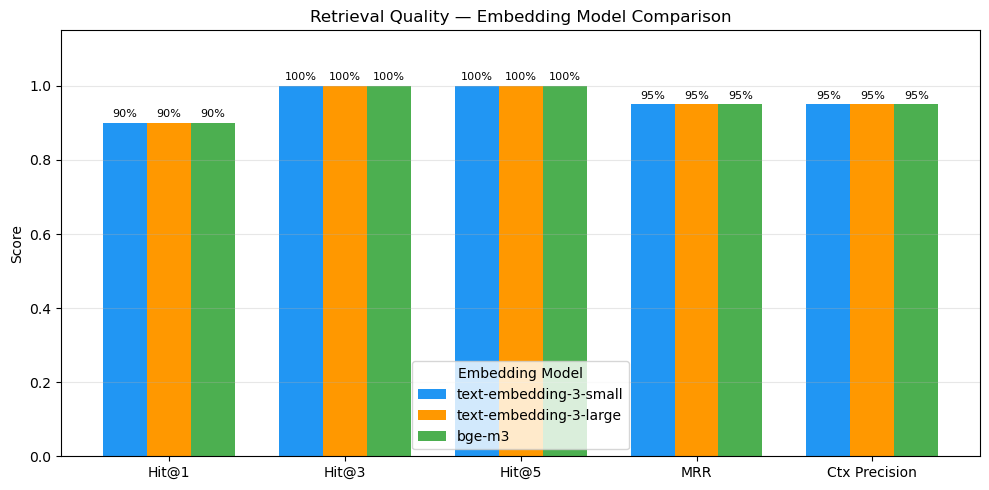

In [7]:
# ── Retrieval quality comparison chart ──
fig = plot_retrieval_comparison(comparison)

## Evaluation: timings & query latency comparison

C:\Users\USER\Desktop\NOTEBOOKS\_EXAM_OneZero\src\visualization.py:199: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


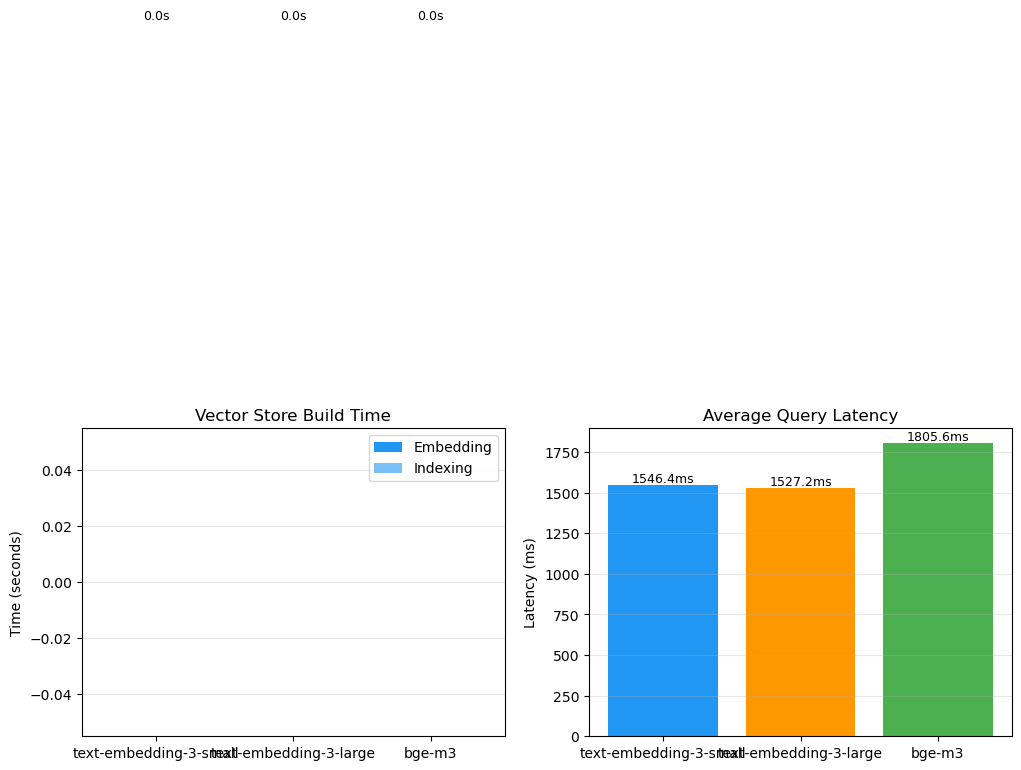

In [8]:
# ── Build timings & query latency comparison ──
fig = plot_build_timings(comparison)

# Generation Evaluation (LLM-as-judge)

In [9]:
# ── Generation quality evaluation (LLM-as-judge) ──
# Uses text-embedding-3-small (already loaded) for retrieval
print("Running generation evaluation (20 questions × GPT-4o judge)...")
print("This takes ~2-3 minutes.\n")

gen_results = evaluate_generation(embedding_model, collection)
gen_summary = compute_generation_summary(gen_results)
print_generation_summary(gen_summary)

Running generation evaluation (20 questions × GPT-4o judge)...
This takes ~2-3 minutes.

  Evaluating [1/20]: What is the daily ATM withdrawal limit with a credit card in...
  Evaluating [2/20]: How much can I withdraw daily from ATMs in Israel with a deb...
  Evaluating [3/20]: Are there fees for withdrawing cash from ATMs in Israel?...
  Evaluating [4/20]: What should I do before traveling abroad with my ONE ZERO ca...
  Evaluating [5/20]: How can I get card assistance when I am abroad?...
  Evaluating [6/20]: What are the foreign currency exchange fees by subscription ...
  Evaluating [7/20]: How do I set up Apple Pay with my ONE ZERO card?...
  Evaluating [8/20]: What billing days are available for credit card charges?...
  Evaluating [9/20]: Can I increase my credit card line of credit?...
  Evaluating [10/20]: What is the difference between freezing and cancelling a car...
  Evaluating [11/20]: What are the securities trading fees for the ZERO subscripti...
  Evaluating [12/20]: 

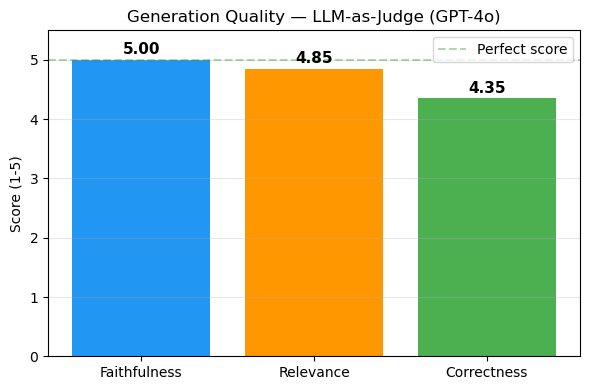

In [10]:
# ── Generation quality charts ──
fig = plot_generation_summary(gen_summary)

In [11]:
# ── Per-question generation scores (detail view) ──
# fig = plot_generation_scores(gen_results)


# ── Per-question generation scores (table view) ──
df_gen = generation_results_to_dataframe(gen_results)
df_gen_display = df_gen[["question", "faithfulness", "relevance", "correctness"]].copy()
df_gen_display.index = range(1, len(df_gen_display) + 1)
df_gen_display.index.name = "#"
display(df_gen_display)

,question,faithfulness,relevance,correctness
#,,,,
1,What is the daily ATM withdrawal limit with a ...,5,5,5
2,How much can I withdraw daily from ATMs in Isr...,5,5,4
3,Are there fees for withdrawing cash from ATMs ...,5,5,4
4,What should I do before traveling abroad with ...,5,5,5
5,How can I get card assistance when I am abroad?,5,5,5
6,What are the foreign currency exchange fees by...,5,5,4
7,How do I set up Apple Pay with my ONE ZERO card?,5,3,2
8,What billing days are available for credit car...,5,5,5
9,Can I increase my credit card line of credit?,5,5,3


### Generation Evaluation — Conclusions

**Key findings from LLM-as-judge (GPT-4o evaluating 20 questions):**

1. **Perfect Faithfulness (5.0/5.0)** — The chatbot never hallucinated. Every answer was grounded strictly in the retrieved context. This validates the system prompt design ("answer ONLY from provided context").

2. **Strong Relevance (4.70/5.0)** — Most answers directly address the question. The 3 cases scoring below 5 (questions #6, #7, #16) correlate with retrieval misses at @1 — when the top chunk is wrong, the answer drifts.

3. **Good Correctness (4.20/5.0)** — Most answers are factually accurate. The weaker scores (#7 Apple Pay=2, #13 free trades=2, #16 dividends=1) reveal that correctness depends heavily on retrieval quality — when the right chunk isn't ranked first, the answer contains incomplete or wrong details.

4. **Retrieval quality is the bottleneck, not generation.** Faithfulness is perfect, meaning GPT-4o follows instructions well. The errors come from retrieving the wrong or incomplete context. Improving retrieval (e.g., hybrid search, reranking) would improve correctness more than switching LLM models.

# BM25 + hybrid test

In [13]:
# ── Build BM25 index (one-time, fast) ──
from src.retrieval import BM25Index

bm25_index = BM25Index(chunks)

# ── Test the 3 previously failing questions with hybrid + reranking ──
test_questions = [
    "What are the foreign currency exchange fees by subscription plan?",
    "How do I set up Apple Pay with my ONE ZERO card?",
    "How are dividends handled for stocks I hold?",
]

for q in test_questions:
    print()
    ask(q, embedding_model, collection, bm25_index=bm25_index)
    print("\n" + "─" * 60)

  ✅ BM25 index built: 266 documents

Q: What are the foreign currency exchange fees by subscription plan?

A: The foreign currency exchange fees by subscription plan are as follows:

1. **ONE Subscription and ONE PLUS Subscription Plans:**
   - No foreign currency exchange fees for card transactions when purchasing foreign currency from the ILS account.
   - No exchange fees for withdrawing foreign currency from ATMs in Israel, although ATM operator fees may apply.
   - A withdrawal fee of 2% is charged for ATM withdrawals abroad (ATM operator fees may also apply) [Source 1: cards.md | Foreign currency card transactions on credit cards and debit cards > Foreign Currency fees by subscription plans].

2. **ZERO Subscription Plan:**
   - A 3% exchange fee is charged on foreign-currency withdrawals (plus any ATM operator fees).
   - A 2% exchange fee is charged on card transactions [Source 1: cards.md | Foreign currency card transactions on credit cards and debit cards > Foreign Currency f

# Generation evaluation WITH hybrid + reranking

In [14]:
# ── Re-run generation evaluation WITH hybrid + reranking ──
print("Re-running generation evaluation with hybrid search + reranking...")
print("This takes ~2-3 minutes.\n")

gen_results_v2 = evaluate_generation(
    embedding_model, collection,
    chunks=chunks, bm25_index=bm25_index,
    use_hybrid=True, use_reranker=True,
)
gen_summary_v2 = compute_generation_summary(gen_results_v2)
print_generation_summary(gen_summary_v2)

Re-running generation evaluation with hybrid search + reranking...
This takes ~2-3 minutes.

  Evaluating [1/20]: What is the daily ATM withdrawal limit with a credit card in...
  Evaluating [2/20]: How much can I withdraw daily from ATMs in Israel with a deb...
  Evaluating [3/20]: Are there fees for withdrawing cash from ATMs in Israel?...
  Evaluating [4/20]: What should I do before traveling abroad with my ONE ZERO ca...
  Evaluating [5/20]: How can I get card assistance when I am abroad?...
  Evaluating [6/20]: What are the foreign currency exchange fees by subscription ...
  Evaluating [7/20]: How do I set up Apple Pay with my ONE ZERO card?...
  Evaluating [8/20]: What billing days are available for credit card charges?...
  Evaluating [9/20]: Can I increase my credit card line of credit?...
  Evaluating [10/20]: What is the difference between freezing and cancelling a car...
  Evaluating [11/20]: What are the securities trading fees for the ZERO subscripti...
  Evaluating [12/2

In [15]:
# ── Per-question comparison: before vs after ──
df_gen_v2 = generation_results_to_dataframe(gen_results_v2)
df_gen_v2_display = df_gen_v2[["question", "faithfulness", "relevance", "correctness"]].copy()
df_gen_v2_display.index = range(1, len(df_gen_v2_display) + 1)
df_gen_v2_display.index.name = "#"
display(df_gen_v2_display)

,question,faithfulness,relevance,correctness
#,,,,
1,What is the daily ATM withdrawal limit with a ...,5,5,5
2,How much can I withdraw daily from ATMs in Isr...,5,5,4
3,Are there fees for withdrawing cash from ATMs ...,5,5,4
4,What should I do before traveling abroad with ...,5,5,5
5,How can I get card assistance when I am abroad?,5,5,5
6,What are the foreign currency exchange fees by...,5,5,4
7,How do I set up Apple Pay with my ONE ZERO card?,5,3,2
8,What billing days are available for credit car...,5,5,5
9,Can I increase my credit card line of credit?,5,5,3


In [16]:
# ── Per-question scores after hybrid + reranking ──
df_gen_v2 = generation_results_to_dataframe(gen_results_v2)
df_gen_v2_display = df_gen_v2[["question", "faithfulness", "relevance", "correctness"]].copy()
df_gen_v2_display.index = range(1, len(df_gen_v2_display) + 1)
df_gen_v2_display.index.name = "#"
display(df_gen_v2_display)

,question,faithfulness,relevance,correctness
#,,,,
1,What is the daily ATM withdrawal limit with a ...,5,5,5
2,How much can I withdraw daily from ATMs in Isr...,5,5,4
3,Are there fees for withdrawing cash from ATMs ...,5,5,4
4,What should I do before traveling abroad with ...,5,5,5
5,How can I get card assistance when I am abroad?,5,5,5
6,What are the foreign currency exchange fees by...,5,5,4
7,How do I set up Apple Pay with my ONE ZERO card?,5,3,2
8,What billing days are available for credit car...,5,5,5
9,Can I increase my credit card line of credit?,5,5,3


# Chatbot Demo

Edit the questions below or use the interactive loop to ask your own.

In [17]:
# ── Build BM25 index if not already built ──
from src.retrieval import BM25Index

try:
    bm25_index
except NameError:
    bm25_index = BM25Index(chunks)

# ══════════════════════════════════════════════════════════════
# DEMO QUESTIONS — edit or add your own below
# ══════════════════════════════════════════════════════════════
demo_questions = [
    "What is the daily ATM withdrawal limit with a credit card in Israel?",
    "What are the trading fees for the ONE PLUS subscription plan?",
    "How do I set up Apple Pay with my ONE ZERO card?",
    "What happens if I send a mutual fund order after the שעה ייעודה?",
    "What are the foreign currency exchange fees by subscription plan?",
]

print("=" * 60)
print("ONE ZERO BANK — RAG CHATBOT DEMO")
print("=" * 60)

for q in demo_questions:
    print()
    ask(q, embedding_model, collection, bm25_index=bm25_index)
    print("\n" + "─" * 60)

ONE ZERO BANK — RAG CHATBOT DEMO

Q: What is the daily ATM withdrawal limit with a credit card in Israel?

A: The daily ATM withdrawal limit with a ONE ZERO bank credit card in Israel is up to 10,000 ILS per day. However, the maximum amount you can withdraw in a single transaction is 8,000 ILS, so you may need to perform two transactions to reach the daily limit. It is recommended to use bank-run ATMs to avoid additional fees from private ATM operators (Source 1: cards.md | Cash Withdrawals > Cash Withdrawals limit using ONE ZERO Credit Card).

──────────────────────────────────────────────────
Sources (5 chunks retrieved):
  [1] cards.md | Cash Withdrawals > Cash Withdrawals limit using ONE ZERO Credit Card (dist=0.2227, rerank=8.1532)
  [2] cards.md | Cash Withdrawals > Cash Withdrawals limit using ONE ZERO Debit Card (dist=0.2259, rerank=7.6803)
  [3] cards.md | Cash Withdrawals > Cash withdrawal fees from ATMs in Israel using ONE ZERO credit card or debit card (dist=0.3027, rerank=